In [2]:
DATASET_PATH = '../data/raw/statue_faces'
MODEL_PATH   = '../models/shape_predictor_68_face_landmarks.dat'

### Import dependencies

In [3]:
import dlib
import cv2
import matplotlib.pyplot as plt
import PIL
import json
import os
from PIL import Image
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(MODEL_PATH)

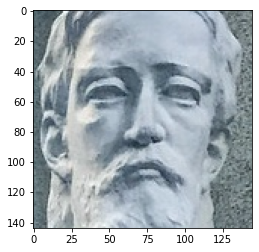

In [4]:
img = cv2.imread('../data/raw/statue_faces/0449.jpg')
plt.imshow(img)

### Rename files in dataset

In [35]:
files = os.listdir(DATASET_PATH)
for k, filename in enumerate(files):
    os.rename(f'{DATASET_PATH}/{filename}', f'{DATASET_PATH}/{(k+1):04d}.jpg')

### Reshape files in dataset to 128 x 128

In [5]:
SHAPE_128x128 = (128, 128)
DATASET_128x128_PATH = '../data/processed/statue_faces_128x128'

In [37]:

files = os.listdir(DATASET_PATH)
for k, filename in enumerate(files):
    img = Image.open(f'{DATASET_PATH}/{filename}')
    resized = img.resize(SHAPE_128x128)
    resized.save(f'{DATASET_128x128_PATH}/{filename}')

### Generate face landmarks for faces in dataset

Will generate a file with shape 
`````json
{
  "0001.jpg": {
    "00": {
      "x": 22,
      "y": 48
    },
    "01": {
      "x": 22,
      "y": 60
    },
    ...
    ,
    "66": {
      "x": 68,
      "y": 89
    },
    "67": {
      "x": 65,
      "y": 87
    },
    "height": 87,
    "left": 26,
    "top": 26,
    "width": 87
  },
  ...
}
`````


In [6]:
files = os.listdir(DATASET_128x128_PATH)
LANDMARKS_JSON_FILEPATH = '../data/processed/statue_faces_128x128_landmarks.json'
landmarks = {}


In [38]:

for file_path in files:
    path = f'{DATASET_128x128_PATH}/{file_path}'
    img = cv2.imread(path)
    faces = detector(img)
    if len(faces) == 1:
        face = faces[0]
        prediction = predictor(img, face)
        face_landmarks = {
            f'{k:02d}': {"x": p.x, "y": p.y}
            for k, p in enumerate(prediction.parts())
        }
        face_landmarks.update({
            "top": face.top(),
            "left": face.left(),
            "width": face.width(),
            "height": face.height()
        })
        landmarks.update({file_path: face_landmarks})

with open(LANDMARKS_JSON_FILEPATH, 'w') as landmarks_output:
    landmarks_output.write(
        json.dumps(landmarks, indent=2, sort_keys=True)
    )

### Generate masks

In [7]:
NUMBER_OF_MASKS = 32
PATH_TO_MASKS_128x128 = '../data/processed/masks_128x128'
MASKS = {}

In [39]:

import random
for i in range(NUMBER_OF_MASKS):    
    blank_image = Image.new('1', SHAPE_128x128, 1)
    delta = 32
    random_x = random.randint(0, 128-32)
    random_x_delta = random_x + delta
    random_y = random.randint(0, 128-32)
    random_y_delta = random_y + delta
    pixels = blank_image.load()
    for x in range(128):
        for y in range(128):
            if x > random_x and x < random_x_delta:
                if y > random_y and y < random_y_delta:
                    random_R = 255
                    random_G = 255
                    random_B = 255
                    pixels[x, y] = 0
    blank_image.save(f'{PATH_TO_MASKS_128x128}/{(i+1):02d}.jpg')
    MASKS.update({
        f'{(i+1):02d}.jpg': {
            "x": random_x,
            "x_delta": random_x_delta,
            "y": random_y,
            "y_delta": random_y_delta
        }
    })


## Mask images

In [8]:
statue_faces_files = os.listdir(DATASET_128x128_PATH)
PATH_TO_MASKED_STATUES = '../data/processed/masked_statue_faces_128x128'
MASKED_DATASET_METADATA = {}
PATH_TO_MASKED_DATASET_METADATA = '../data/processed/masked_statue_faces_128x128_metadata.json'

In [12]:
count = 0
import tqdm
import random
for statue_face_file in tqdm.tqdm(statue_faces_files):
    count += 1
    for i in range(1, 12):
        mask_id = f'{i:02d}'
        statue_face_fp = f'{DATASET_128x128_PATH}/{statue_face_file}'
        statue_face_img = Image.open(statue_face_fp)
        statue_face_pixels = statue_face_img.load()
        delta = 32
        random_x = random.randint(0, 128-32)
        random_x_delta = random_x + delta
        random_y = random.randint(0, 128-32)
        random_y_delta = random_y + delta
        for x in range(128):
            for y in range(128):
                if x > random_x and x < random_x_delta and y > random_y and y < random_y_delta:
                    random_R = 0
                    random_G = 0
                    random_B = 0
                    statue_face_pixels[x, y] = (random_R, random_G, random_B)
        img_name = f'source_%s-mask_%s.jpg' % (statue_face_file.split('.')[0], mask_id.split('.')[0])
        MASKED_DATASET_METADATA[img_name] = {
            'source': f'{DATASET_128x128_PATH}/{statue_face_file}',
            'mask': f'{PATH_TO_MASKS_128x128}/{mask_id}',
        }
        statue_face_img.save(f'{PATH_TO_MASKED_STATUES}/{img_name}')

with open(PATH_TO_MASKED_DATASET_METADATA, 'w') as metadata_path:
    metadata_path.write(
        json.dumps(
            MASKED_DATASET_METADATA, indent=2, sort_keys=True
        )
    )

100%|██████████| 1292/1292 [00:23<00:00, 55.34it/s]


## TODO

1. generate face landmarks for masked images ✅
2. generate XML landmarks for masked images ✅
3. train dlib shape predictor with masked faces ✅

In [14]:
import random
with open(PATH_TO_MASKED_DATASET_METADATA, 'r') as masked_statues_metadata_fp:
    masked_statues_metadata = json.load(masked_statues_metadata_fp)
    masked_statues = list(masked_statues_metadata.keys())
    random.shuffle(masked_statues)
    MASKED_STATUES_TRAIN = masked_statues[0: 8000]
    MASKED_STATUES_TEST  = masked_statues[8001: 9001]

    print('Train dataset:', len(MASKED_STATUES_TRAIN))
    print('Test dataset:', len(MASKED_STATUES_TEST))

Train dataset: 8000
Test dataset: 1000


In [18]:
"""
Generate training face landmarks for masked images
"""
import random
from pprint import pprint


with open(LANDMARKS_JSON_FILEPATH, 'r') as landmarks_fp:
    landmarks = json.load(landmarks_fp)

masked_statues_landmarks = {
    filename: landmarks[masked_statues_metadata[filename]['source'].split('/')[-1]]
    for filename in MASKED_STATUES_TRAIN
    if masked_statues_metadata[filename]['source'].split('/')[-1] in landmarks.keys()
}
LANDMARKS_XML_FILEPATH = '../data/processed/masked_statue_faces_predictor_train.xml'
MASKED_STATUES_DATASET_FULL_PATH = os.path.join(os.getcwd(), PATH_TO_MASKED_STATUES)
xml_images = ''
for file in masked_statues_landmarks.keys():
    xml_images += f"    <image file='/Users/lmontana/Master/deep-statue-inpainting/data/processed/masked_statue_faces_128x128/{file}' width='128' height='128'>\n"
    data = masked_statues_landmarks[file]
    top, left, width, height = data['top'], data['left'], data['width'], data['height']
    xml_images += f"        <box top='{top}' left='{left}' width='{width}' height='{height}'>\n"

    for part in data.keys():
        if part not in ["top", "left", "width", "height"]:
            xml_images += f"            <part name='{part}' x='{data[part]['x']}' y='{data[part]['y']}'/>\n"
    
    xml_images += f"        </box>\n"
    xml_images += f"    </image>\n"

xml_content = f'''<dataset>
<name>Training masked statue faces</name>
<comment>These are images made using statue images found from flickr.
   The face landmarks are from dlib's shape_predictor_68_face_landmarks.dat
   landmarking model.</comment>
<images>
{xml_images}</images>
</dataset>'''

with open(LANDMARKS_XML_FILEPATH, 'w') as train_xml:
    train_xml.write(xml_content) 


In [19]:
"""
Generate testing face landmarks for masked images
"""
import random
from pprint import pprint

with open(LANDMARKS_JSON_FILEPATH, 'r') as landmarks_fp:
    landmarks = json.load(landmarks_fp)

masked_statues_landmarks = {
    filename: landmarks[masked_statues_metadata[filename]['source'].split('/')[-1]]
    for filename in MASKED_STATUES_TEST
    if masked_statues_metadata[filename]['source'].split('/')[-1] in landmarks.keys()
}
LANDMARKS_XML_FILEPATH = '../data/processed/masked_statue_faces_predictor_test.xml'
MASKED_STATUES_DATASET_FULL_PATH = os.path.join(os.getcwd(), PATH_TO_MASKED_STATUES)
xml_images = ''
for file in masked_statues_landmarks.keys():
    xml_images += f"    <image file='/Users/lmontana/Master/deep-statue-inpainting/data/processed/masked_statue_faces_128x128/{file}' width='128' height='128'>\n"
    data = masked_statues_landmarks[file]
    top, left, width, height = data['top'], data['left'], data['width'], data['height']
    xml_images += f"        <box top='{top}' left='{left}' width='{width}' height='{height}'>\n"

    for part in data.keys():
        if part not in ["top", "left", "width", "height"]:
            xml_images += f"            <part name='{part}' x='{data[part]['x']}' y='{data[part]['y']}'/>\n"
    
    xml_images += f"        </box>\n"
    xml_images += f"    </image>\n"

xml_content = f'''<dataset>
<name>Testing masked statue faces</name>
<comment>These are images made using statue images found from flickr.
   The face landmarks are from dlib's shape_predictor_68_face_landmarks.dat
   landmarking model.</comment>
<images>
{xml_images}</images>
</dataset>'''

with open(LANDMARKS_XML_FILEPATH, 'w') as train_xml:
    train_xml.write(xml_content) 


### Train shape predictor for masked statue faces

In [20]:
# The predictor is trained following the documentation by dlib
# http://dlib.net/train_shape_predictor.py.html

import os
import sys
import glob

import dlib

# In this example we are going to train a face detector based on the
# masked statue faces dataset in the data/processed/masked_statue_faces_128x128 directory.

faces_folder = '/Users/lmontana/Master/deep-statue-inpainting/data/processed/masked_statue_faces_128x128'

options = dlib.shape_predictor_training_options()
# Now make the object responsible for training the model.
# This algorithm has a bunch of parameters you can mess with.  The
# documentation for the shape_predictor_trainer explains all of them.
# You should also read Kazemi's paper which explains all the parameters
# in great detail.  However, here I'm just setting three of them
# differently than their default values.  I'm doing this because we
# have a very small dataset.  In particular, setting the oversampling
# to a high amount (300) effectively boosts the training set size, so
# that helps this example.
options.oversampling_amount = 30
# I'm also reducing the capacity of the model by explicitly increasing
# the regularization (making nu smaller) and by using trees with
# smaller depths.
#options.nu = 0.05
#options.tree_depth = 2
#options.be_verbose = True

# dlib.train_shape_predictor() does the actual training.  It will save the
# final predictor to predictor.dat.  The input is an XML file that lists the
# images in the training dataset and also contains the positions of the face
# parts.
training_xml_path = '/Users/lmontana/Master/deep-statue-inpainting/data/processed/masked_statue_faces_predictor_train.xml'
dlib.train_shape_predictor(training_xml_path, "predictor.dat", options)

# Now that we have a model we can test it.  dlib.test_shape_predictor()
# measures the average distance between a face landmark output by the
# shape_predictor and where it should be according to the truth data.
print("\nTraining accuracy: {}".format(
    dlib.test_shape_predictor(training_xml_path, "predictor.dat")))
# The real test is to see how well it does on data it wasn't trained on.  We
# trained it on a very small dataset so the accuracy is not extremely high, but
# it's still doing quite good.  Moreover, if you train it on one of the large
# face landmarking datasets you will obtain state-of-the-art results, as shown
# in the Kazemi paper.
testing_xml_path = '/Users/lmontana/Master/deep-statue-inpainting/data/processed/masked_statue_faces_predictor_test.xml'
print("Testing accuracy: {}".format(
    dlib.test_shape_predictor(testing_xml_path, "predictor.dat")))

# Now let's use it as you would in a normal application.  First we will load it
# from disk. We also need to load a face detector to provide the initial
# estimate of the facial location.
predictor = dlib.shape_predictor("predictor.dat")
detector = dlib.get_frontal_face_detector()

# Now let's run the detector and shape_predictor over the images in the faces
# folder and display the results.


Training accuracy: 0.985464153347779
Testing accuracy: 1.3014579167977907


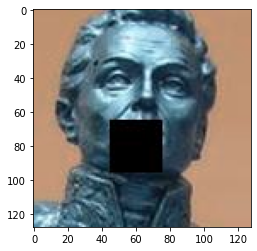

In [29]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('../data/processed/masked_statue_faces_128x128/source_0001-mask_09.jpg')
plt.imshow(img)
plt.show()

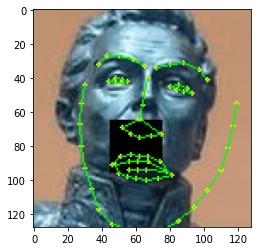

In [30]:

landmark_tuple = []
d = dlib.rectangle(0, 0, 128, 128)
landmarks = predictor(img, d)
for n in range(0, 68):
    x = landmarks.part(n).x
    y = landmarks.part(n).y
    landmark_tuple.append((x, y))
    cv2.circle(img, (x, y), 1, (255, 255, 0), -1)
for i in range(0, 16):
    cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
for i in range(17, 21):
    cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
for i in range(22, 26):
    cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
for i in range(27, 35):
    cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
cv2.line(img, (landmarks.part(30).x, landmarks.part(30).y), (landmarks.part(35).x, landmarks.part(35).y), (0, 255, 0), 1)
for i in range(36, 41):
    cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
cv2.line(img, (landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(41).x, landmarks.part(41).y), (0, 255, 0), 1)
for i in range(42, 47):
    cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
cv2.line(img, (landmarks.part(42).x, landmarks.part(42).y), (landmarks.part(47).x, landmarks.part(47).y), (0, 255, 0), 1)
for i in range(48, 67):
    cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    
plt.imshow(img)
plt.show()

In [31]:
def check_img(masked_img_path):
    import cv2
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 30))
    
    original_filename = masked_img_path.split('/')[-1].split('-')[0].split('_')[-1] + '.jpg'
    original_path = '../data/processed/statue_faces_128x128/' + original_filename
    original_img = cv2.imread(original_path)
    axes[0].imshow(original_img)
    axes[0].set_title('Original image')
    

    img_masked = cv2.imread(masked_img_path)
    axes[1].imshow(img_masked)
    axes[1].set_title('Masked image')

    img = cv2.imread(masked_img_path)


    face = dlib.rectangle(0, 0, 128, 128)
    landmarks = predictor(img, face)
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmark_tuple.append((x, y))
        cv2.circle(img, (x, y), 1, (255, 255, 0), -1)
    for i in range(0, 16):
        cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    for i in range(17, 21):
        cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    for i in range(22, 26):
        cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    for i in range(27, 35):
        cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    cv2.line(img, (landmarks.part(30).x, landmarks.part(30).y), (landmarks.part(35).x, landmarks.part(35).y), (0, 255, 0), 1)
    for i in range(36, 41):
        cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    cv2.line(img, (landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(41).x, landmarks.part(41).y), (0, 255, 0), 1)
    for i in range(42, 47):
        cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    cv2.line(img, (landmarks.part(42).x, landmarks.part(42).y), (landmarks.part(47).x, landmarks.part(47).y), (0, 255, 0), 1)
    for i in range(48, 67):
        cv2.line(img, (landmarks.part(i).x, landmarks.part(i).y), (landmarks.part(i+1).x, landmarks.part(i+1).y), (0, 255, 0), 1)
    axes[2].imshow(img)
    axes[2].set_title('Reconstruction image')
    
    plt.show()

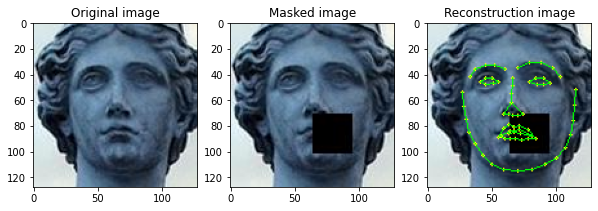

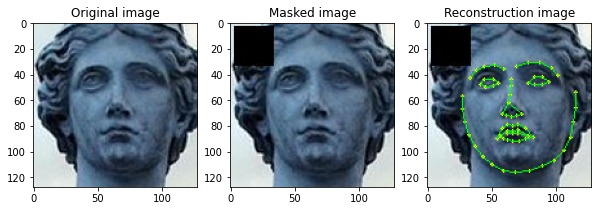

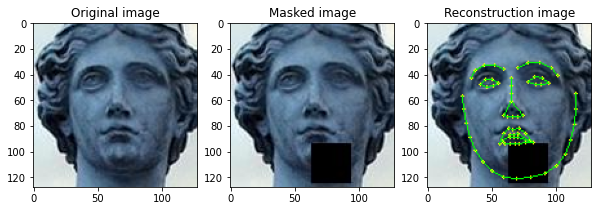

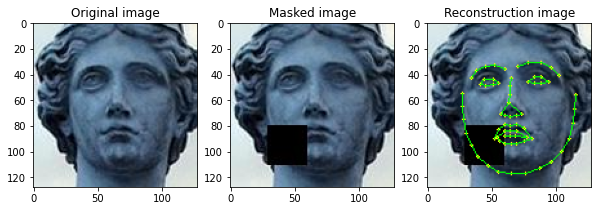

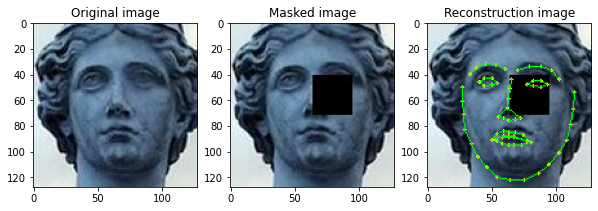

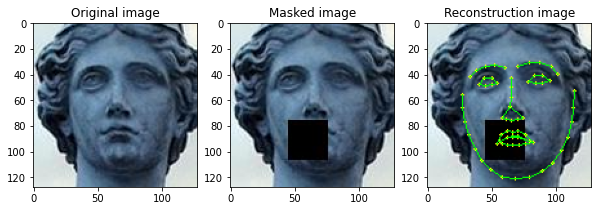

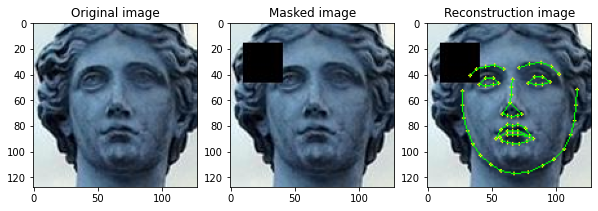

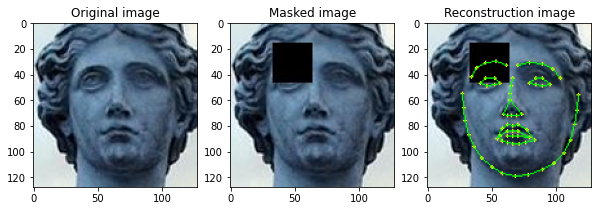

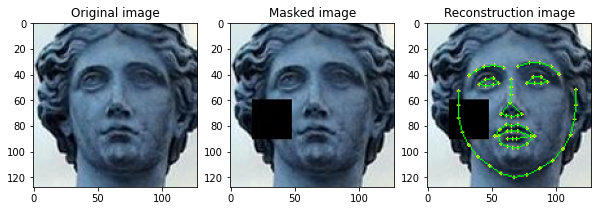

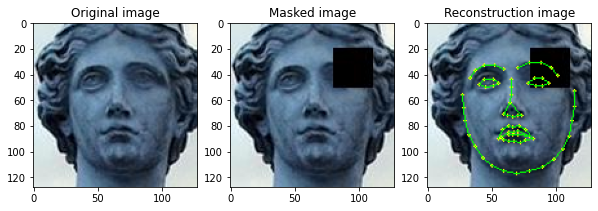

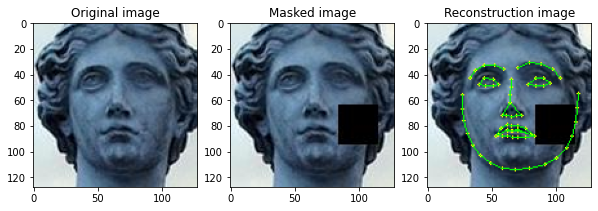

In [39]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_1596'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)

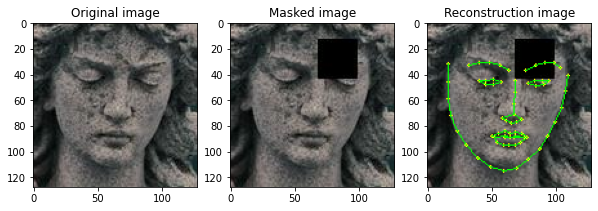

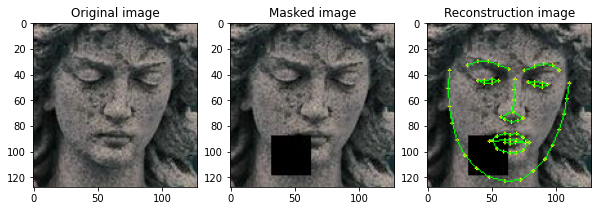

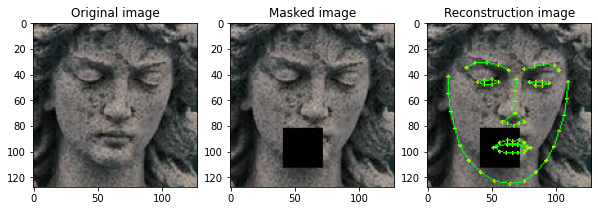

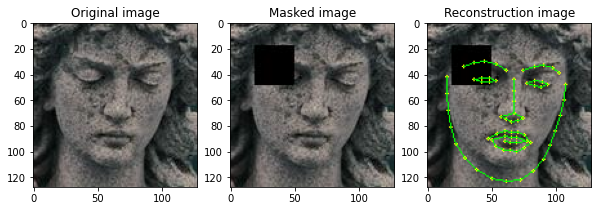

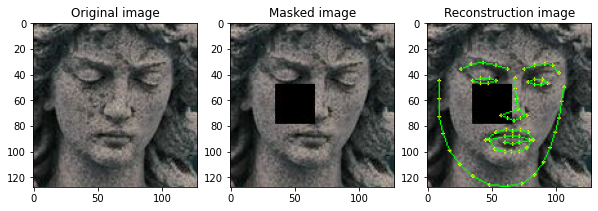

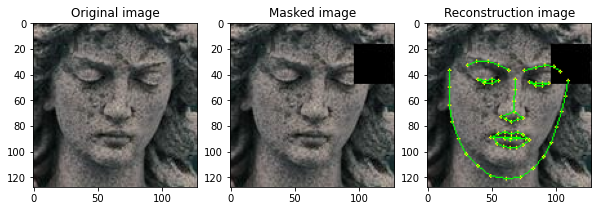

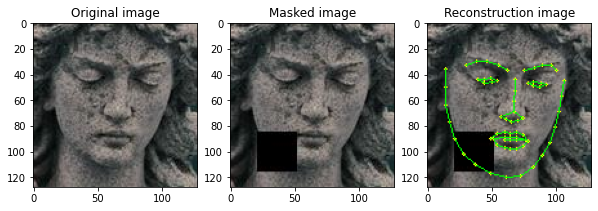

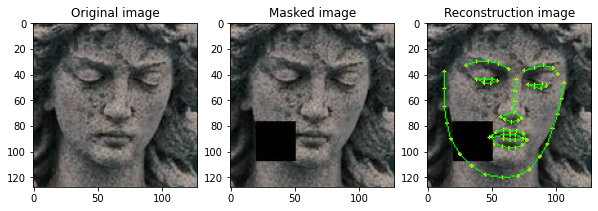

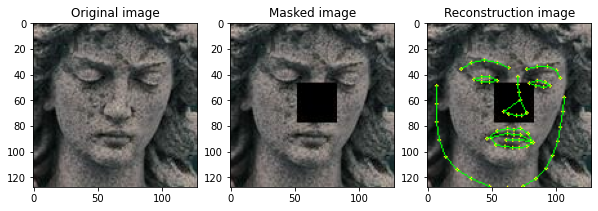

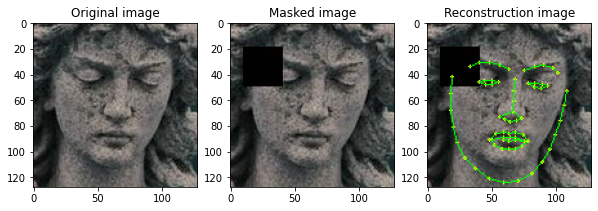

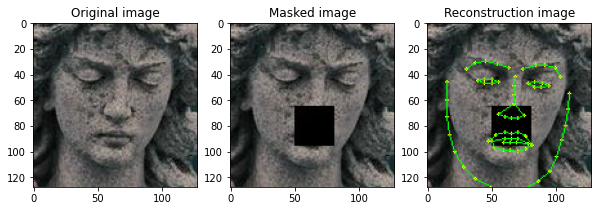

In [38]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_0273'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)

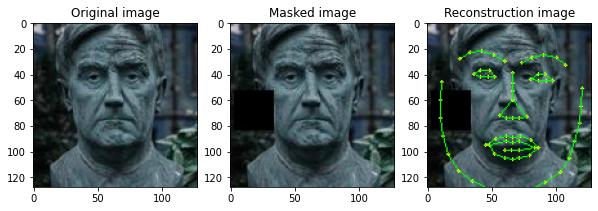

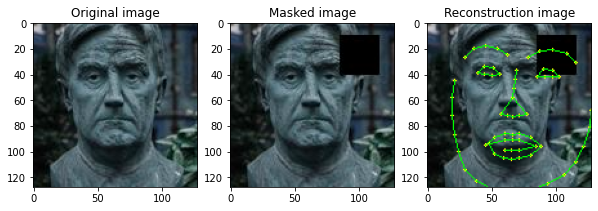

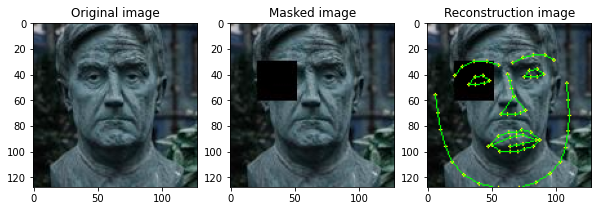

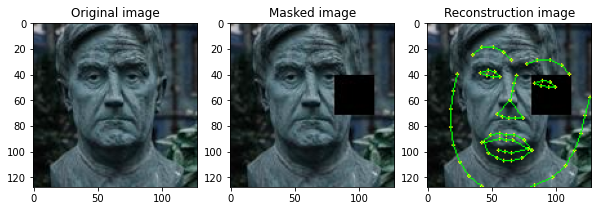

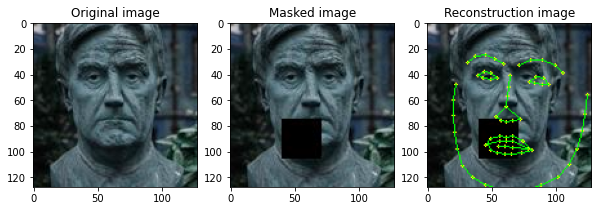

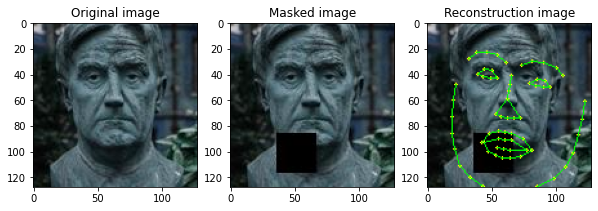

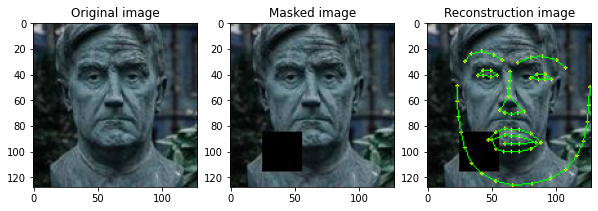

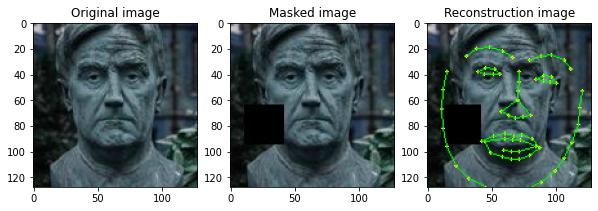

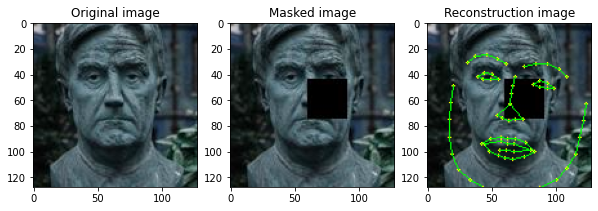

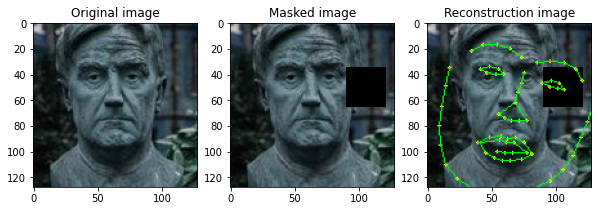

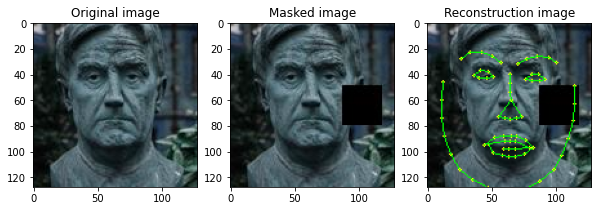

In [40]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_1569'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)

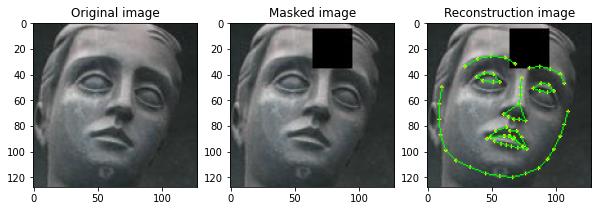

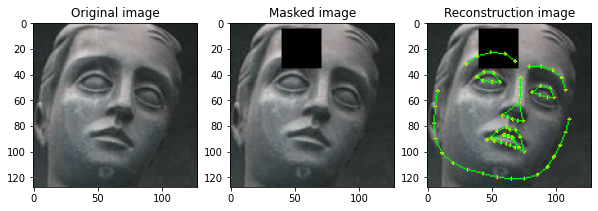

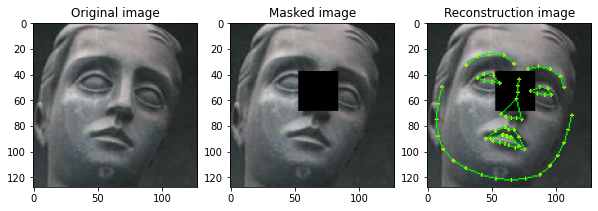

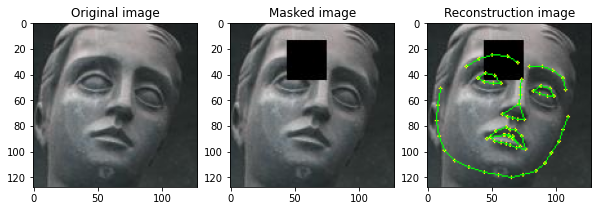

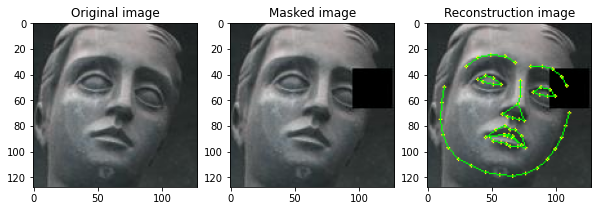

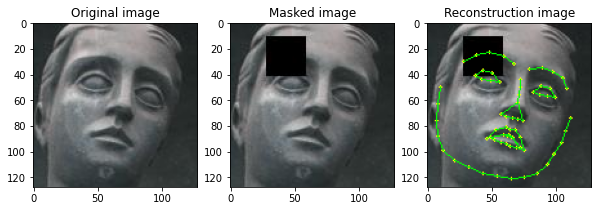

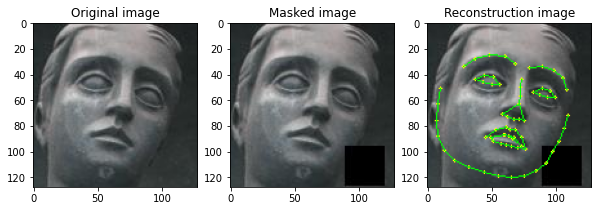

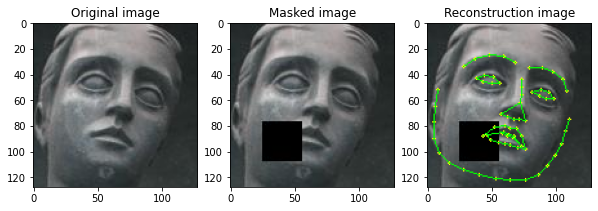

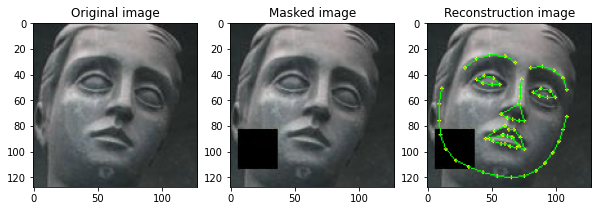

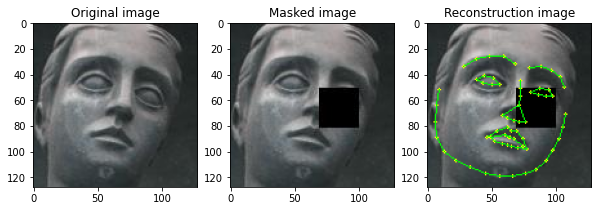

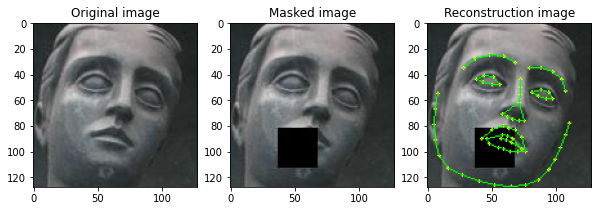

In [41]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_1426'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)

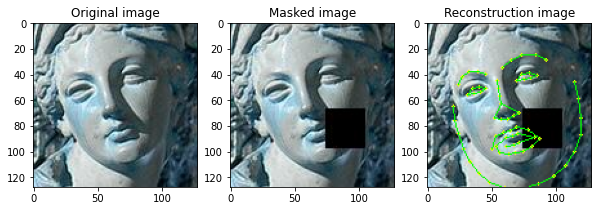

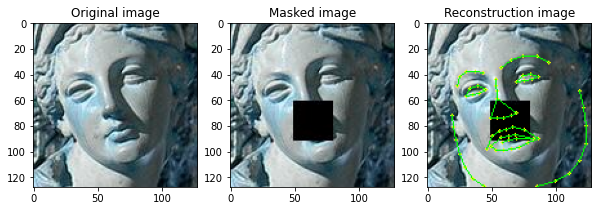

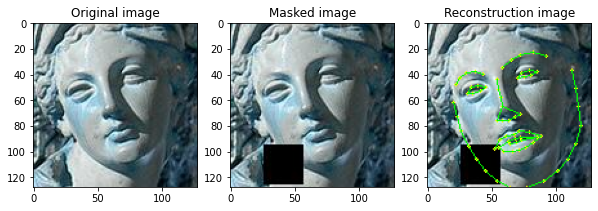

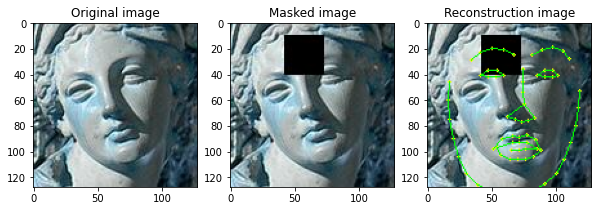

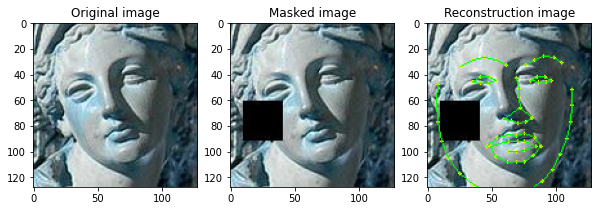

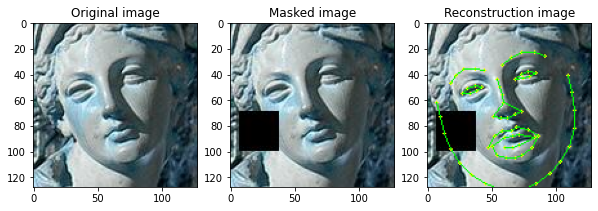

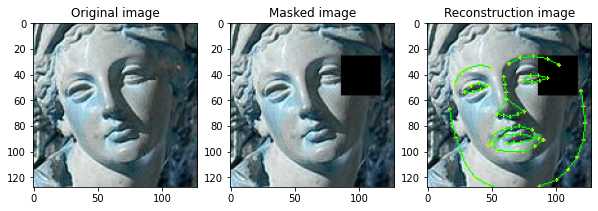

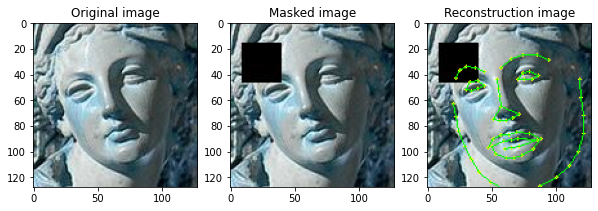

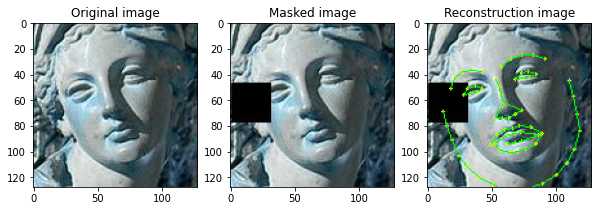

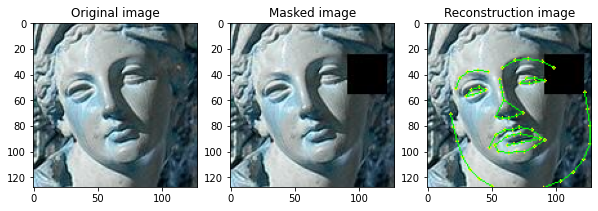

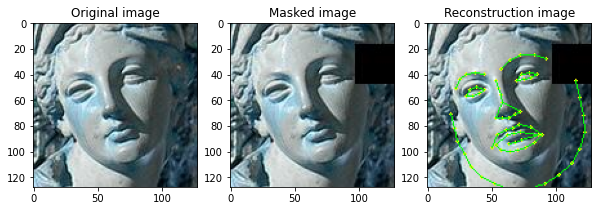

In [42]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_1509'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)

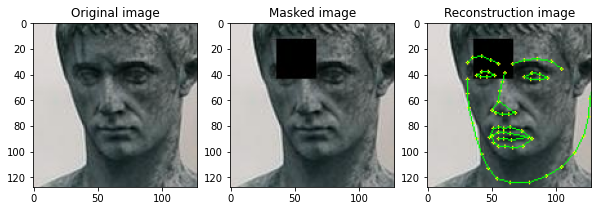

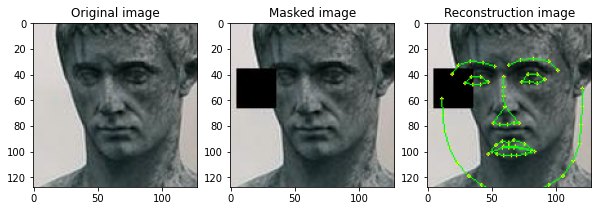

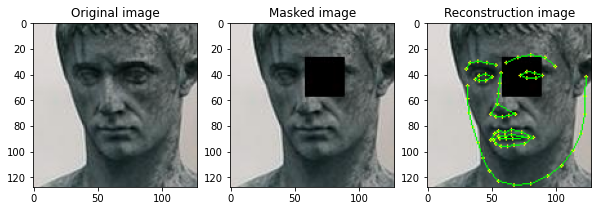

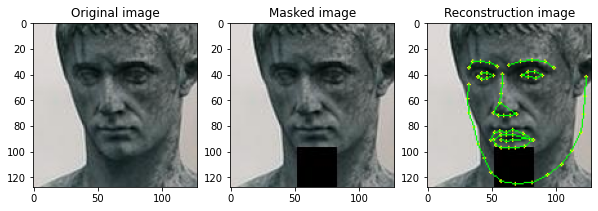

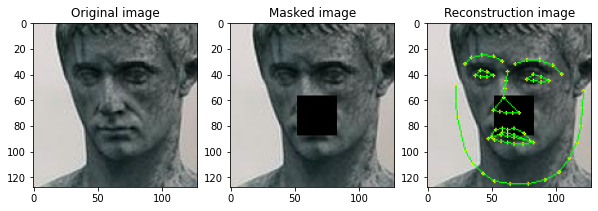

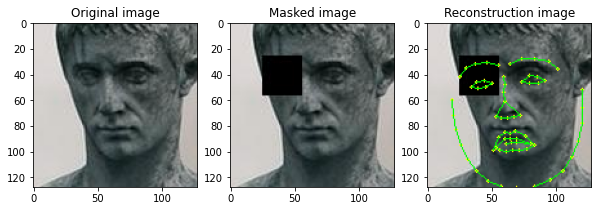

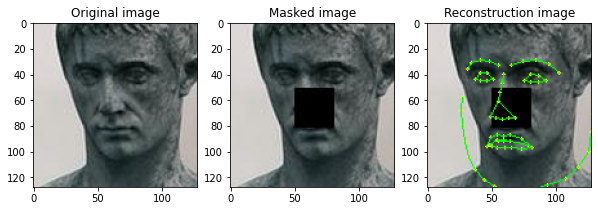

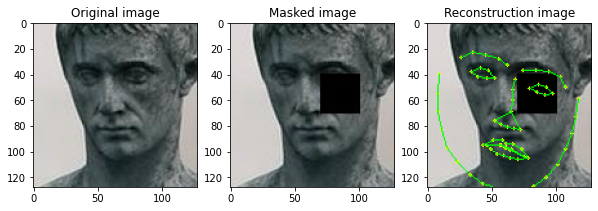

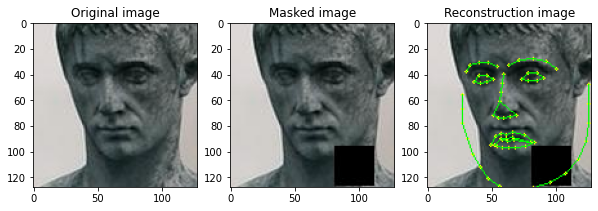

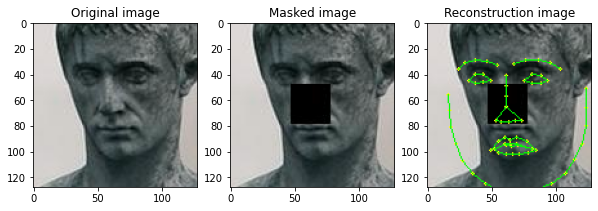

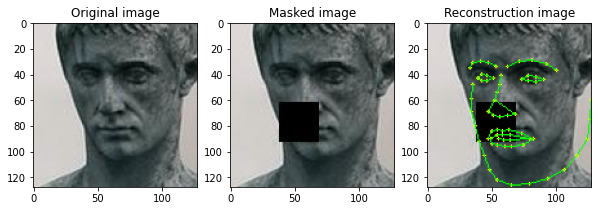

In [43]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_1134'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)

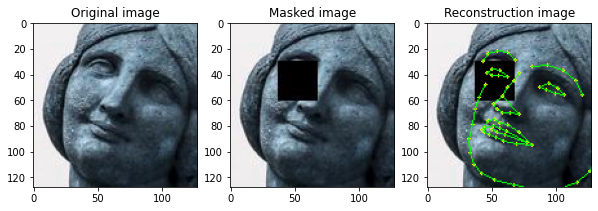

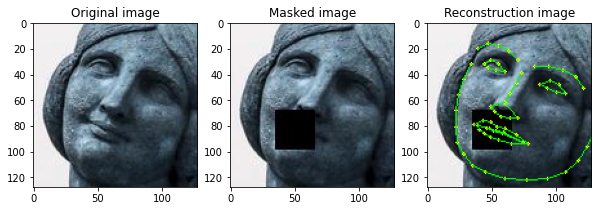

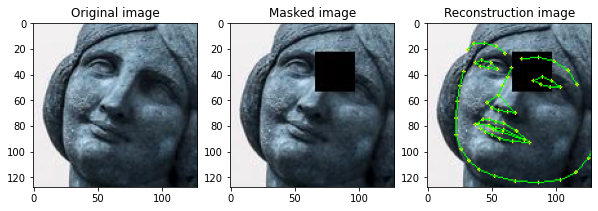

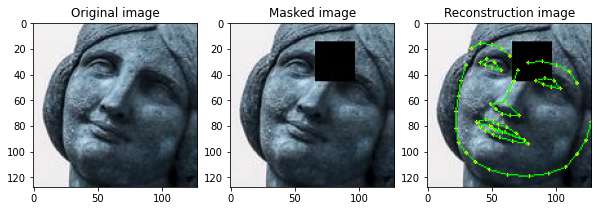

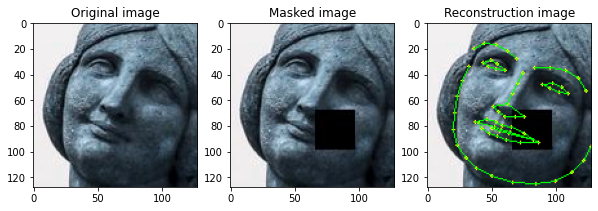

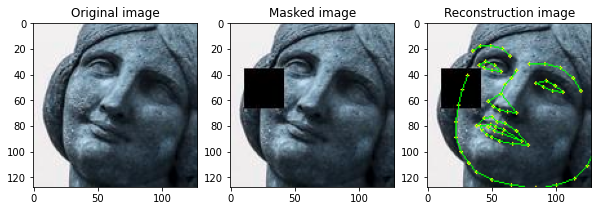

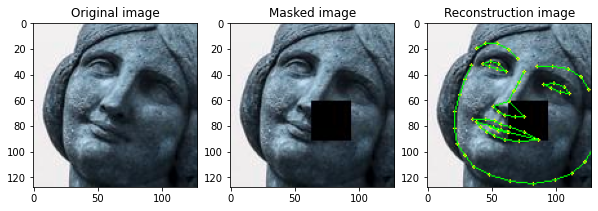

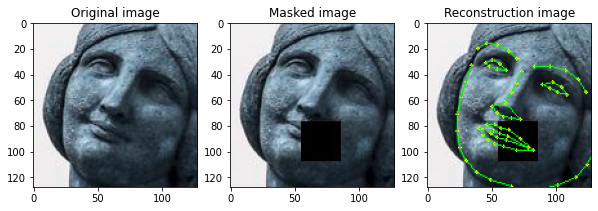

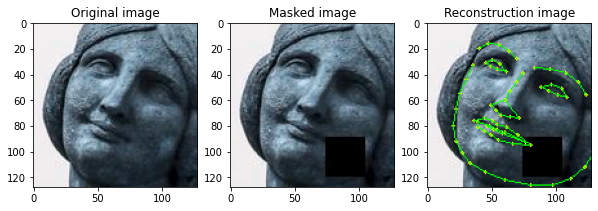

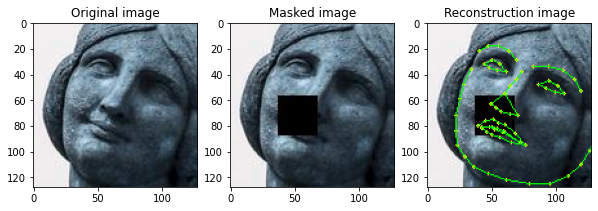

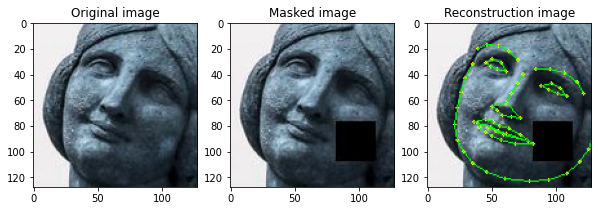

In [44]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_0967'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)

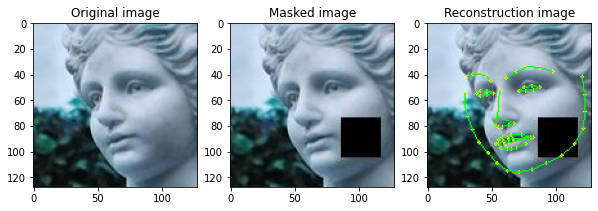

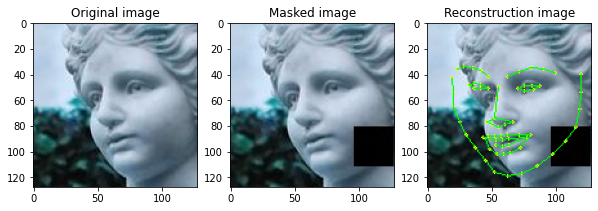

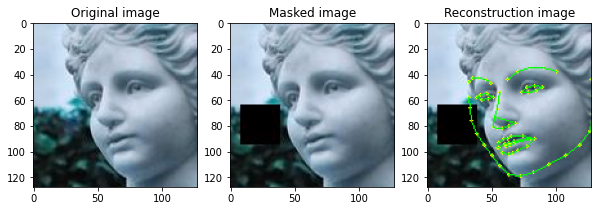

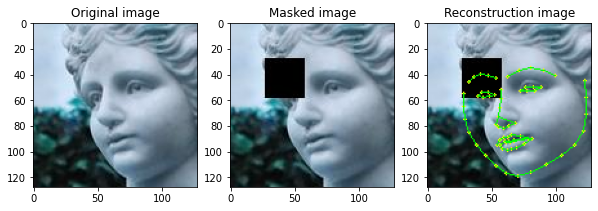

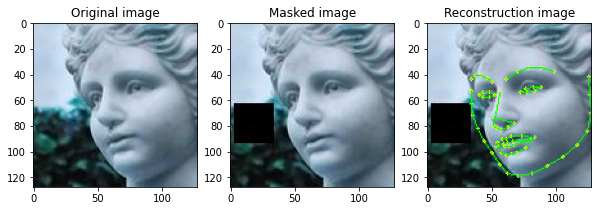

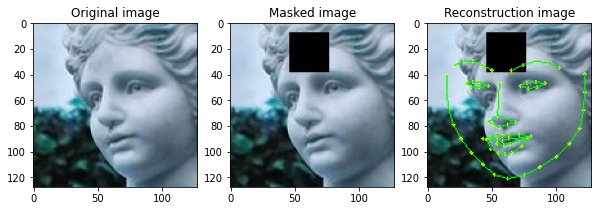

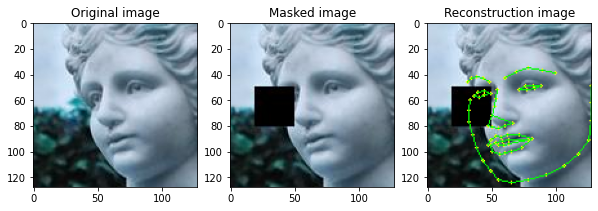

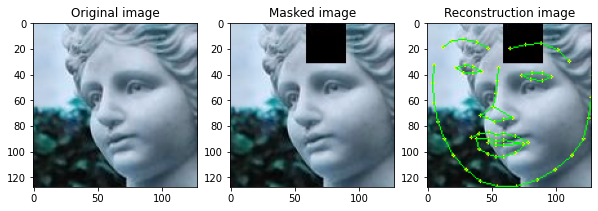

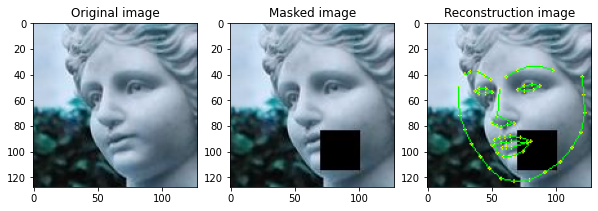

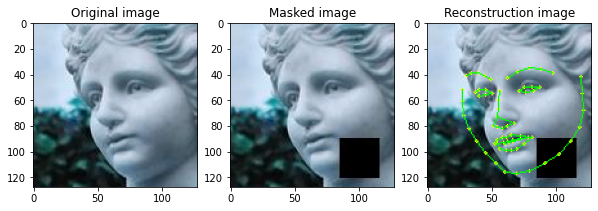

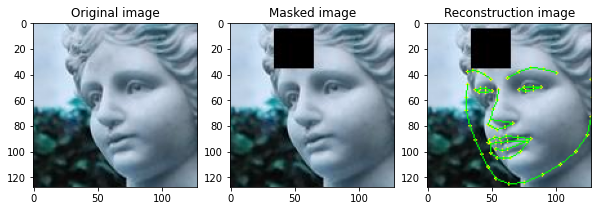

In [45]:
for image in os.listdir('../data/processed/masked_statue_faces_128x128/'):
    if image.startswith('source_0006'):
        check_img('../data/processed/masked_statue_faces_128x128/'+image)